# Component 4: Feature Visualization

Extract deep features and visualize using t-SNE, UMAP, and hierarchical clustering

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import umap
from scipy.cluster.hierarchy import dendrogram, linkage
from tqdm.auto import tqdm
import os

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

OUTPUT_DIR = '../outputs/features'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("✓ Setup complete")

✓ Setup complete


## 4.1 Load Data & Extract Features

In [2]:
# Load full dataset manifest
full_df = pd.read_csv('../outputs/dataset_manifest.csv')

# Sample up to 4000 images for efficiency
MAX_SAMPLES = min(4000, len(full_df))
sample_df = full_df.sample(n=MAX_SAMPLES, random_state=SEED)

print(f"Extracting features from {len(sample_df)} images...")
print(f"Class distribution in sample:")
print(sample_df['class_name'].value_counts())

# Load pretrained ResNet50 for feature extraction
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    pooling='avg',
    weights='imagenet',
    input_shape=(224, 224, 3)
)

print(f"\n✓ Loaded ResNet50 (feature dim: 2048)")

Extracting features from 4000 images...
Class distribution in sample:
class_name
Normal         2754
1 Very Mild     770
2 Mild          317
3 Moderate      159
Name: count, dtype: int64


2026-01-28 23:39:15.761162: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2026-01-28 23:39:15.761201: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2026-01-28 23:39:15.761211: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2026-01-28 23:39:15.761235: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-01-28 23:39:15.761248: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)



✓ Loaded ResNet50 (feature dim: 2048)


In [3]:
# Extract features
features = []
labels = []
class_names = []

print("\nExtracting features...")
for _, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
    try:
        # Load and preprocess image
        img = tf.keras.preprocessing.image.load_img(
            row['filepath'], target_size=(224, 224)
        )
        x = tf.keras.preprocessing.image.img_to_array(img)
        x = tf.keras.applications.resnet50.preprocess_input(x)
        x = np.expand_dims(x, axis=0)
        
        # Extract features
        feat = base_model.predict(x, verbose=0)[0]
        
        features.append(feat)
        labels.append(row['class_label'])
        class_names.append(row['class_name'])
    except Exception as e:
        print(f"Error processing {row['filepath']}: {e}")

features = np.array(features)
labels = np.array(labels)

print(f"\n✓ Extracted features: {features.shape}")

# Save features
np.save(f'{OUTPUT_DIR}/features_resnet50.npy', features)
np.save(f'{OUTPUT_DIR}/labels.npy', labels)
print(f"✓ Features saved to {OUTPUT_DIR}/")


Extracting features...


  0%|          | 0/4000 [00:00<?, ?it/s]

2026-01-28 23:39:17.187027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.



✓ Extracted features: (4000, 2048)
✓ Features saved to ../outputs/features/


## 4.2 t-SNE Visualization


Computing t-SNE (this may take a few minutes)...


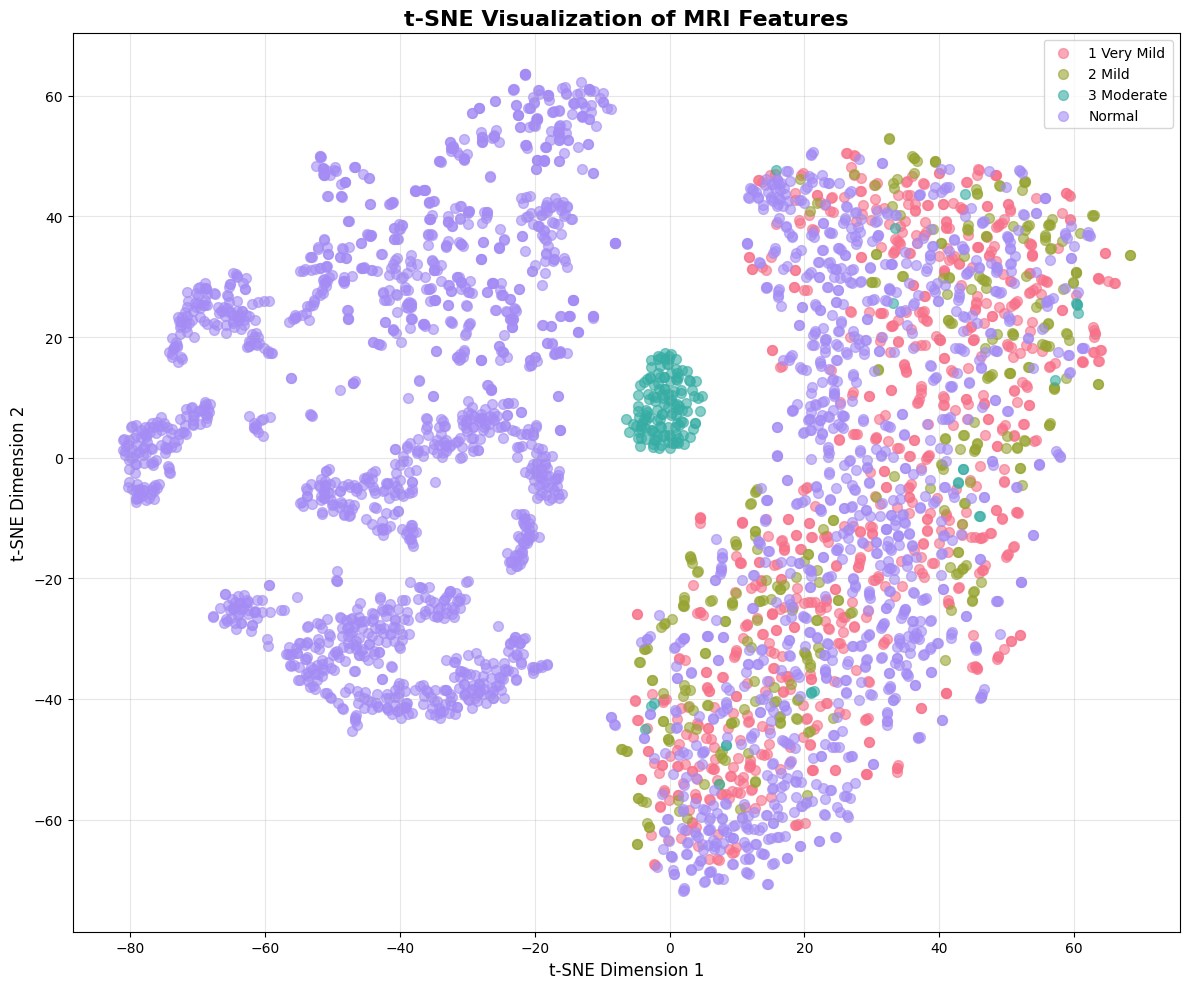

✓ t-SNE visualization saved


In [5]:
# Apply t-SNE
print("\nComputing t-SNE (this may take a few minutes)...")
tsne = TSNE(n_components=2, random_state=SEED, perplexity=30, max_iter=1000)
tsne_embeddings = tsne.fit_transform(features)

# Save embeddings
tsne_df = pd.DataFrame(tsne_embeddings, columns=['x', 'y'])
tsne_df['label'] = labels
tsne_df['class_name'] = class_names
tsne_df.to_csv(f'{OUTPUT_DIR}/tsne_embeddings.csv', index=False)

# Visualize
plt.figure(figsize=(12, 10))
unique_classes = sorted(set(class_names))
colors = sns.color_palette('husl', len(unique_classes))

for idx, class_name in enumerate(unique_classes):
    mask = np.array(class_names) == class_name
    plt.scatter(
        tsne_embeddings[mask, 0],
        tsne_embeddings[mask, 1],
        label=class_name,
        alpha=0.6,
        s=50,
        color=colors[idx]
    )

plt.title('t-SNE Visualization of MRI Features', fontsize=16, fontweight='bold')
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/tsne_plot.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ t-SNE visualization saved")

## 4.3 UMAP Visualization


Computing UMAP...


/Users/amitabhthakur/Workspace/Projects/ML/AD/venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


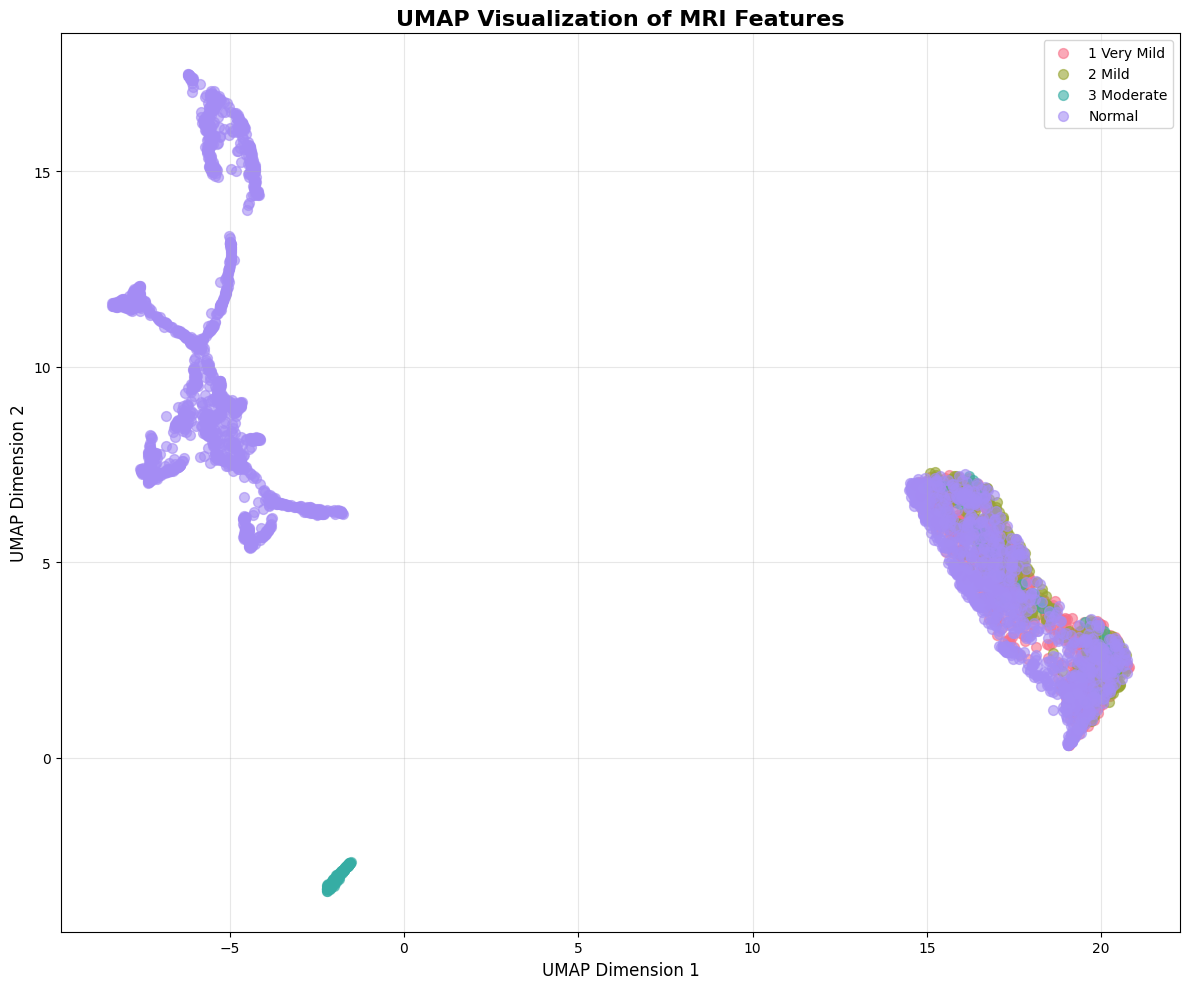

✓ UMAP visualization saved


In [6]:
# Apply UMAP
print("\nComputing UMAP...")
reducer = umap.UMAP(random_state=SEED, n_neighbors=15, min_dist=0.1)
umap_embeddings = reducer.fit_transform(features)

# Save embeddings
umap_df = pd.DataFrame(umap_embeddings, columns=['x', 'y'])
umap_df['label'] = labels
umap_df['class_name'] = class_names
umap_df.to_csv(f'{OUTPUT_DIR}/umap_embeddings.csv', index=False)

# Visualize
plt.figure(figsize=(12, 10))

for idx, class_name in enumerate(unique_classes):
    mask = np.array(class_names) == class_name
    plt.scatter(
        umap_embeddings[mask, 0],
        umap_embeddings[mask, 1],
        label=class_name,
        alpha=0.6,
        s=50,
        color=colors[idx]
    )

plt.title('UMAP Visualization of MRI Features', fontsize=16, fontweight='bold')
plt.xlabel('UMAP Dimension 1', fontsize=12)
plt.ylabel('UMAP Dimension 2', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/umap_plot.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ UMAP visualization saved")

## 4.4 Hierarchical Clustering Tree


Computing hierarchical clustering on 500 samples...


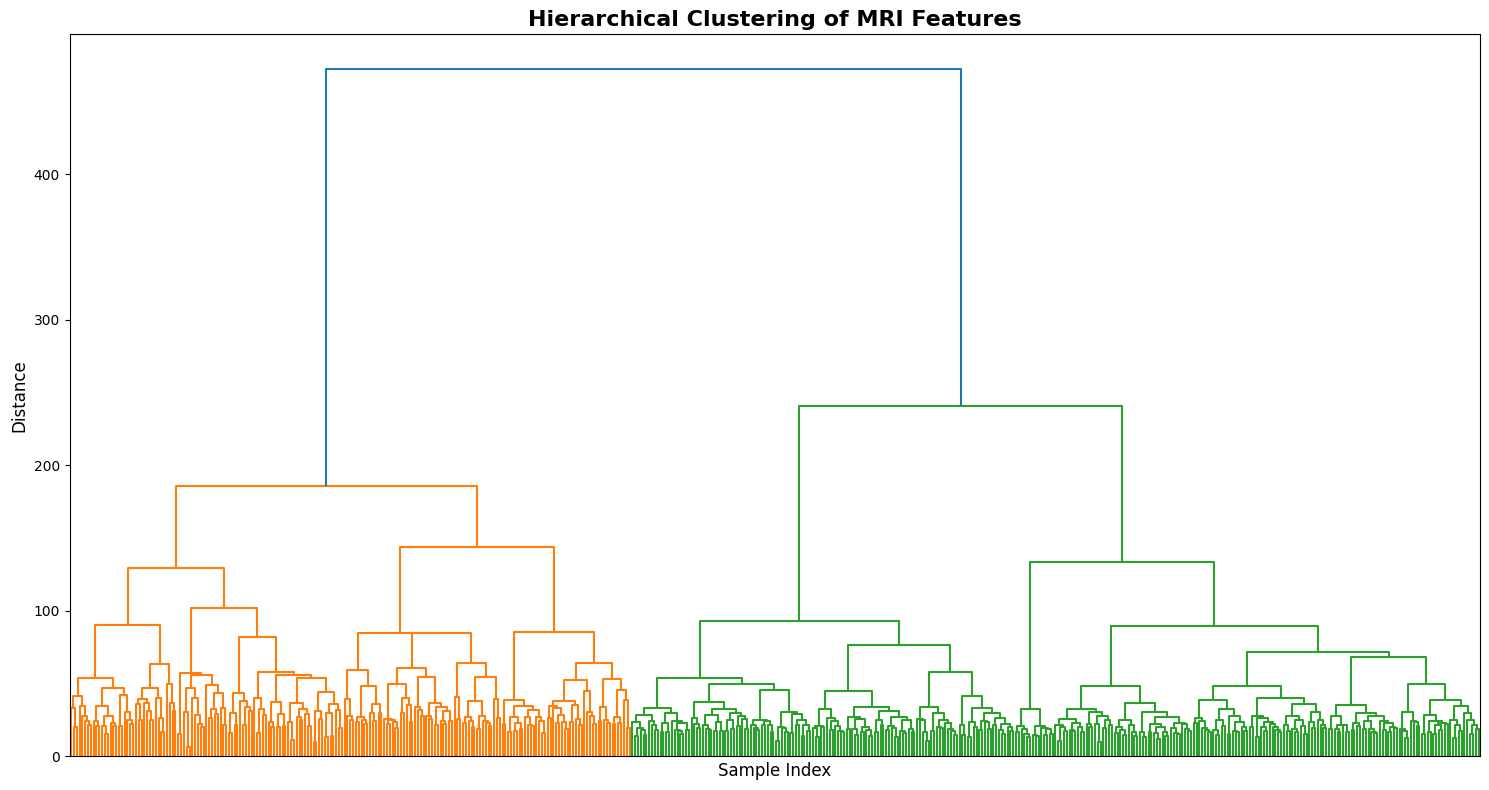

✓ Tree map saved


In [7]:
# Sample subset for tree visualization (hierarchical clustering is O(n²))
TREE_SAMPLES = min(500, len(features))
sample_indices = np.random.choice(len(features), TREE_SAMPLES, replace=False)
sample_features = features[sample_indices]

print(f"\nComputing hierarchical clustering on {TREE_SAMPLES} samples...")
Z = linkage(sample_features, method='ward')

# Visualize dendrogram
plt.figure(figsize=(15, 8))
dendrogram(Z, no_labels=True)
plt.title('Hierarchical Clustering of MRI Features', fontsize=16, fontweight='bold')
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/tmap_plot.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Tree map saved")

## 4.5 Summary

In [8]:
print("\n" + "="*60)
print("✅ FEATURE VISUALIZATION COMPLETE")
print("="*60)
print(f"\nArtifacts saved to: {OUTPUT_DIR}/")
print(f"  - features_resnet50.npy ({features.shape})")
print(f"  - labels.npy ({labels.shape})")
print(f"  - tsne_embeddings.csv")
print(f"  - umap_embeddings.csv")
print(f"  - tsne_plot.png")
print(f"  - umap_plot.png")
print(f"  - tmap_plot.png")
print("\nKey observations:")
print("  - Check if classes form distinct clusters")
print("  - Overlapping regions may indicate similar features")
print("  - t-SNE preserves local structure, UMAP preserves global")


✅ FEATURE VISUALIZATION COMPLETE

Artifacts saved to: ../outputs/features/
  - features_resnet50.npy ((4000, 2048))
  - labels.npy ((4000,))
  - tsne_embeddings.csv
  - umap_embeddings.csv
  - tsne_plot.png
  - umap_plot.png
  - tmap_plot.png

Key observations:
  - Check if classes form distinct clusters
  - Overlapping regions may indicate similar features
  - t-SNE preserves local structure, UMAP preserves global
